# Traitement des données

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
from sklearn.metrics import plot_confusion_matrix
from IPython.display import Image
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import NearMiss
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

#on importe le csv dans un dataframe
df = pd.read_csv('fraude_points.csv', sep=';')

df.copy()

,transactionId,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
1008208,6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
1008209,6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
1008210,6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
1008211,6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


In [52]:
#permet d'afficher les 5 premières lignes du dataframe, ainsi que toutes les colonnes
df.head()

,transactionId,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [53]:
#permet d'avoir la forme du tableau, nombre de lignes x nombres de colonnes
df.shape

(1008213, 11)

In [54]:
#permet de vérifier si des valeurs sont nulles dans le dataframe
df.isnull().sum()

transactionId     0
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [55]:
#on s'intéresse à la colonne "type", en regardant les différents éléments faisant partie de cette colonne, ainsi 
#que le nombre de valeurs attribués à ces éléments.
df['type'].value_counts()

CASH_OUT    366632
PAYMENT     329867
CASH_IN     218938
TRANSFER     86301
DEBIT         6475
Name: type, dtype: int64

In [56]:
#on associe les valeurs de la colonne "isFraud" aux valeurs de la colonne "type".
df[['type', 'isFraud']].groupby(['type'], as_index = False).mean().sort_values(by = 'type', ascending = True)

,type,isFraud
0,CASH_IN,0.000000
1,CASH_OUT,0.011227
2,DEBIT,0.000000
3,PAYMENT,0.000000
4,TRANSFER,0.047473


In [57]:
#permet de regarder dans quels types de transactions se trouvent les fraudes

print('\n Les 2 différents types de transactions frauduleuses sont {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) 

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n Le nombre de TRANSFER frauduleux = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n Le nombre de CASH_OUT frauduleux = {}'.\
       format(len(dfFraudCashout))) # 4116


 Les 2 différents types de transactions frauduleuses sont ['TRANSFER', 'CASH_OUT']

 Le nombre de TRANSFER frauduleux = 4097

 Le nombre de CASH_OUT frauduleux = 4116


In [58]:
#on attribue les mêmes valeurs pour les types n'ayant pas de fraude, et 2 valeurs distinctes pour les 2 autres types
#contenant des fraudes.
df.loc[(df.type == 'CASH_IN') | (df.type == 'DEBIT') | (df.type == 'PAYMENT'), 'type'] = 0
df.loc[df.type == 'CASH_OUT', 'type'] = 1
df.loc[df.type == 'TRANSFER', 'type'] = 2

In [59]:
#pour simplifier le travail sur les données, on convertie les valeurs de la colonne type qui sont des strings, en entiers.
df['type'] = df['type'].astype(int)

isFraud,0,1
type,,
0,555280,0
1,362516,4116
2,82204,4097


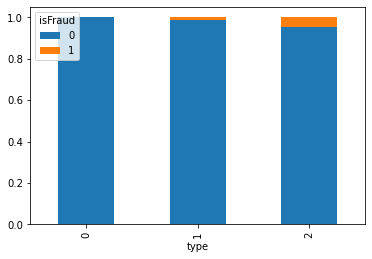

In [60]:
#ce graphique nous permet de voir la proportion de fraude dans chacun des types
table = pd.crosstab(df.type, df.isFraud)
table.div(table.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True)
table.head()

In [61]:
#on supprime les colonnes qui sont les moins utiles à la prédiction de fraude
df.drop(['transactionId','nameOrig','nameDest', 'oldbalanceOrg', 'oldbalanceDest', 'newbalanceDest', 'newbalanceOrig'],axis=1,inplace=True)

In [62]:
#on vérifie bien que les colonnes ont disparu
df.head(5)

,step,type,amount,isFraud
0,1,0,9839.64,0
1,1,0,1864.28,0
2,1,2,181.00,1
3,1,1,181.00,1
4,1,0,11668.14,0


In [63]:
#on vérifie bien que les colonnes ont disparu
df.columns

Index(['step', 'type', 'amount', 'isFraud'], dtype='object')

In [64]:
#on sépare les variables catégoriques et variables numériques dans 2 listes
var_cat=['type']
var_num=['step', 'amount', 'isFraud']
print('les variables catégoriques sont :', var_cat)
print('les variables numériques sont :', var_num)

les variables catégoriques sont : ['type']
les variables numériques sont : ['step', 'amount', 'isFraud']


In [65]:
#on vérifie le % de non-fraude (0) et de fraude (1)
df['isFraud'].value_counts(normalize=True)*100

0    99.18539
1     0.81461
Name: isFraud, dtype: float64

<AxesSubplot:>

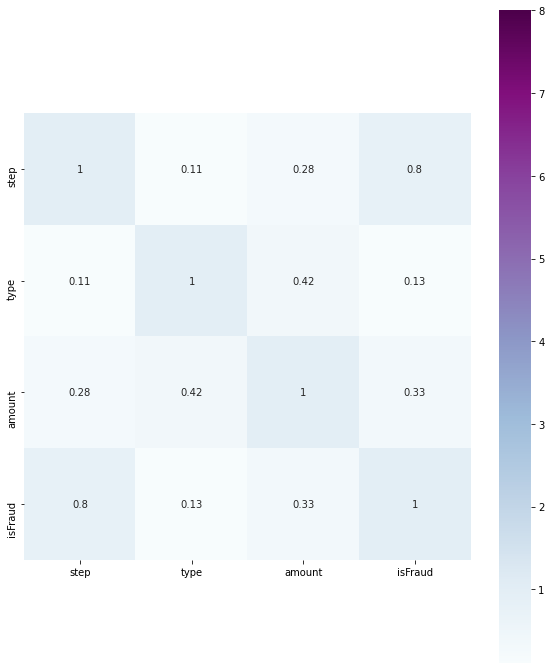

In [66]:
# correlation des variables numériques visuel
matrix=df.corr()
f,ax=plt.subplots(figsize=(10,12))
sns.heatmap(matrix, vmax=8, square=True, cmap='BuPu', annot=True)

In [67]:
#un autre moyen de voir la corrélation entre les différentes features
df.corr()

,step,type,amount,isFraud
step,1.000000,0.113224,0.275325,0.798710
type,0.113224,1.000000,0.420369,0.134807
amount,0.275325,0.420369,1.000000,0.332146
isFraud,0.798710,0.134807,0.332146,1.000000


# Mise en place des variables pour les modèles

In [68]:
#on attribue dans un dataframe les valeurs catégoriques
df_cat=df[var_cat]
df_cat

,type
0,0
1,0
2,2
3,1
4,0
...,...
1008208,1
1008209,2
1008210,1
1008211,2


In [69]:
#on attribue dans un dataframe les valeurs numériques
df_num=df[var_num]
df_num

,step,amount,isFraud
0,1,9839.64,0
1,1,1864.28,0
2,1,181.00,1
3,1,181.00,1
4,1,11668.14,0
...,...,...,...
1008208,743,339682.13,1
1008209,743,6311409.28,1
1008210,743,6311409.28,1
1008211,743,850002.52,1


In [70]:
#Concatenage des 2 DataFrames pour vérifier
df_encoded=pd.concat([df_cat,df_num], axis=1)
df_encoded.head(5)

,type,step,amount,isFraud
0,0,1,9839.64,0
1,0,1,1864.28,0
2,2,1,181.00,1
3,1,1,181.00,1
4,0,1,11668.14,0


In [71]:
#On définit la Target qu'on met dans une variable y, ici "isFraud"
y=df_encoded['isFraud']
y

0          0
1          0
2          1
3          1
4          0
          ..
1008208    1
1008209    1
1008210    1
1008211    1
1008212    1
Name: isFraud, Length: 1008213, dtype: int64

In [72]:
#On met ensuite dans X les autres colonnes, sauf "isFraud"
X=df_encoded.drop('isFraud', axis=1)
X

,type,step,amount
0,0,1,9839.64
1,0,1,1864.28
2,2,1,181.00
3,1,1,181.00
4,0,1,11668.14
...,...,...,...
1008208,1,743,339682.13
1008209,2,743,6311409.28
1008210,1,743,6311409.28
1008211,2,743,850002.52


# Menu des modèles

Utilisez les chiffres pour naviguer :
1/ Modèle de Regression Logistique
2/ Modèle d'Arbre de décision
3/ Modèle de Random Forest
Veuillez entrer un chiffre correspondant au menu souhaité : 1
Utilisez les chiffres pour naviguer :
1/ Regression logistique normale
2/ Regression logistique par over-fitting (SMOTE)
3/ Regression logistique par under-fitting (NearMiss)
4/ Retour au menu principal
Veuillez entrer un chiffre correspondant au menu souhaité : 2
Modèle d'overfitting avec SMOTE


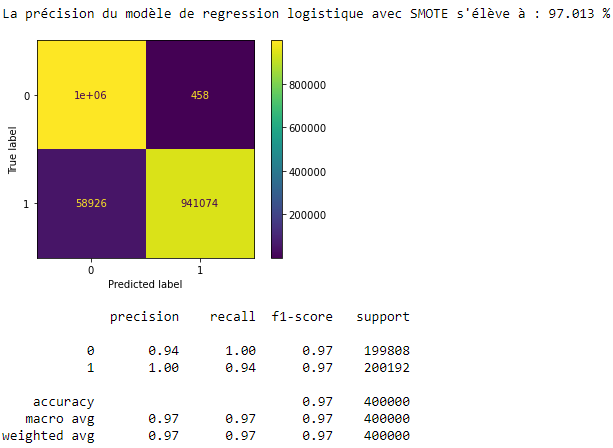

Veuillez entrer un chiffre correspondant au menu souhaité : 4
Utilisez les chiffres pour naviguer :
1/ Modèle de Regression Logistique
2/ Modèle d'Arbre de décision
3/ Modèle de Random Forest
Veuillez entrer un chiffre correspondant au menu souhaité : 3
Utilisez les chiffres pour naviguer :
1/ Random forest normale
2/ Random forest par over-fitting (SMOTE)
3/ Random forest par under-fitting (NearMiss)
4/ Retour au menu principal
Veuillez entrer un chiffre correspondant au menu souhaité : 1
Modèle normale de random forest


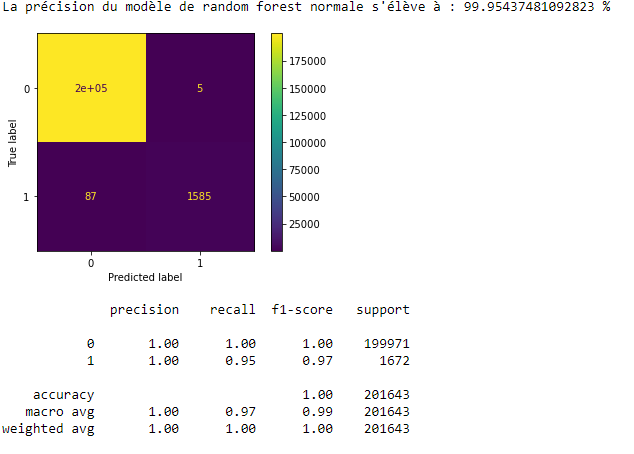

Veuillez entrer un chiffre correspondant au menu souhaité : 4
Utilisez les chiffres pour naviguer :
1/ Modèle de Regression Logistique
2/ Modèle d'Arbre de décision
3/ Modèle de Random Forest
Veuillez entrer un chiffre correspondant au menu souhaité : 2
Utilisez les chiffres pour naviguer :
1/ Arbre de décision normal
2/ Arbre de décision par over-fitting (SMOTE)
3/ Arbre de décision par under-fitting (NearMiss)
4/ Retour au menu principal
Veuillez entrer un chiffre correspondant au menu souhaité : 3
Modèle d'underfitting d'arbre de décision


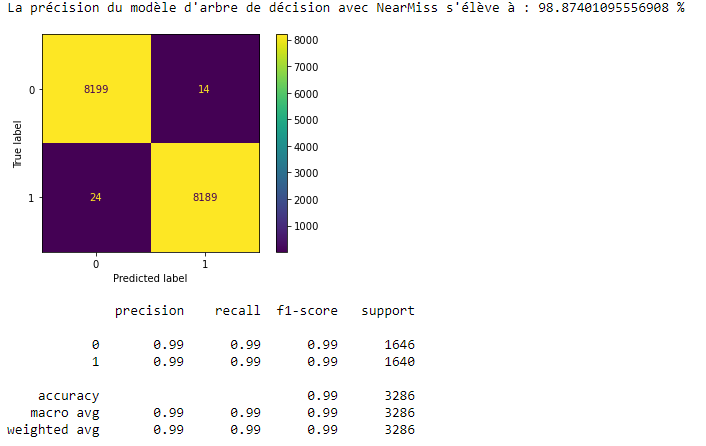

In [ ]:
def main():
    
    print ("Utilisez les chiffres pour naviguer :")
    print ("1/ Modèle de Regression Logistique")
    print ("2/ Modèle d'Arbre de décision")
    print ("3/ Modèle de Random Forest")
    
    #x doit etre un chiffre et sinon ne pas renvoyer d'erreurs
    
    x = True
    while x != False: 
        x = input("Veuillez entrer un chiffre correspondant au menu souhaité : ")
        #navigation
        if x == "1" :
            reg_log2()
        elif x == "2" :
            dt2()
        elif x == "3" :
            rf2()

main()

# Régression Logistique

In [26]:
def reg_log2() :
    print("Utilisez les chiffres pour naviguer :")
    print ("1/ Regression logistique normale")
    print ("2/ Regression logistique par over-fitting (SMOTE)")
    print ("3/ Regression logistique par under-fitting (NearMiss)")
    print ("4/ Retour au menu principal")
    #x doit etre un chiffre et sinon ne pas renvoyer d'erreurs
    x = True
    while x != False: 
        x = input("Veuillez entrer un chiffre correspondant au menu souhaité : ")
        if x == "1" :
            reg_log()
        elif x == "2" :
            reg_log_smote()
        elif x == "3" :
            reg_log_nm()
        elif x == "4" :
            main()
            
reg_log2()

Utilisez les chiffres pour naviguer :
1/ Regression logistique normale
2/ Regression logistique par over-fitting (SMOTE)
3/ Regression logistique par under-fitting (NearMiss)
4/ Retour au menu principal


KeyboardInterrupt: Interrupted by user

In [ ]:
#gridsearch qui a permis de trouver le meilleur solver
#from sklearn.model_selection import GridSearchCV
#params = {'solver':['liblinear','newton-cg','saga','sag','lbfgs'],}
#grid = GridSearchCV(LogisticRegression(),params)
#grid.fit(x_train,y_train)
#print(grid.best_params_);

# Régression logistique normale

Modèle de régression logistique


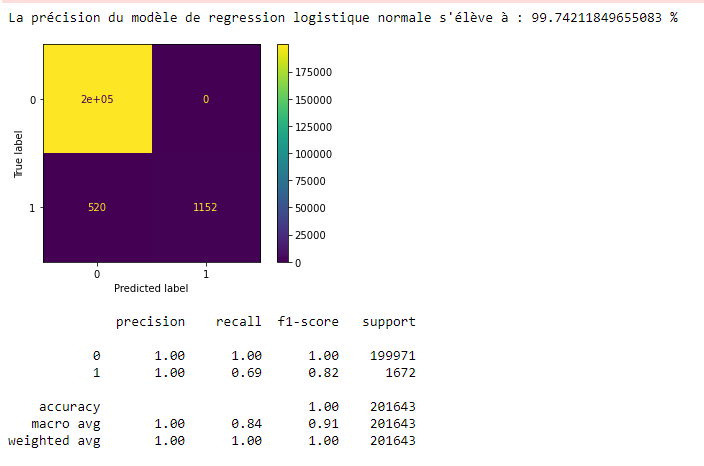

In [27]:
def reg_log():
    
    #redéfinition des variables
    #X=df_encoded.drop('isFraud', axis=1)
    #y=df_encoded['isFraud']
    
    # spécifier la partie test et la partie train (20% - 80%)
    #x_train,x_test,y_train,y_test=ytrain_test_split(X,y,test_size=0.2,random_state=42)
    
    # instancier le modèle
    #clf=LogisticRegression(solver='newton-cg')
    
    # entraîner le modèle
    #clf.fit(x_train,y_train)
    #pred=clf.predict(x_test)
    
    #print("La précision du modèle de regression logistique normale s'élève à :", accuracy_score(y_test,pred)*100, "%")
    
    #plot_confusion_matrix(clf, x_test, y_test)  
    #plt.show()
    
    #print(classification_report(y_test,pred))
    
    #affichage de la capture des résultats
    print("Modèle de régression logistique")
    display(Image(filename='reg_log.png')) 
    
    
    
reg_log()

# Régression logistique avec SMOTE

Modèle d'overfitting avec SMOTE


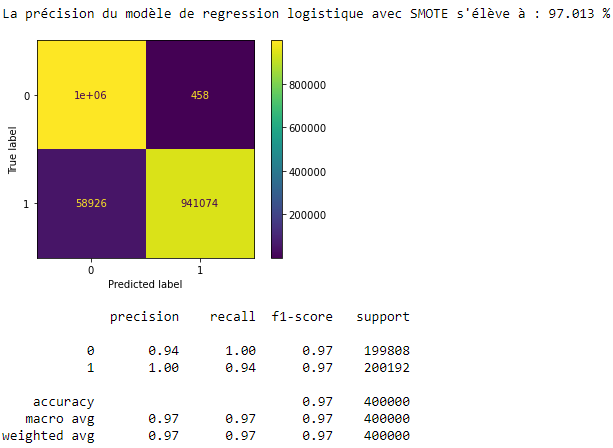

In [44]:
def reg_log_smote():
    
    #redéfinition des variables
    #X=df_encoded.drop('isFraud', axis=1)
    #y=df_encoded['isFraud']

    #data = df.values
    
    #mise en place du SMOTE
    #seed = 5
    #smote = SMOTE(sampling_strategy='auto', random_state=seed,k_neighbors=7)
    #x_smote, y_smote = smote.fit_sample(X, y)
    #summarize distribution
    #print(smote)

    #x_train,x_test,y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)

        # instancier le modèle
    #clf=LogisticRegression(solver='newton-cg')

        # entraîner le modèle
    #clf.fit(x_train,y_train)
    #pred=clf.predict(x_test)

    #print("La précision du modèle de regression logistique avec SMOTE s'élève à :", accuracy_score(y_test,pred)*100, "%")

    #plot_confusion_matrix(clf, x_smote, y_smote)  
    #plt.show()

    #print(classification_report(y_test,pred))
    
    #affichage de la capture des résultats
    print("Modèle d'overfitting avec SMOTE")
    display(Image(filename='reg_log_smote.png')) 

reg_log_smote()

# Régression logistique avec NearMiss

Modèle d'underfitting avec NearMiss


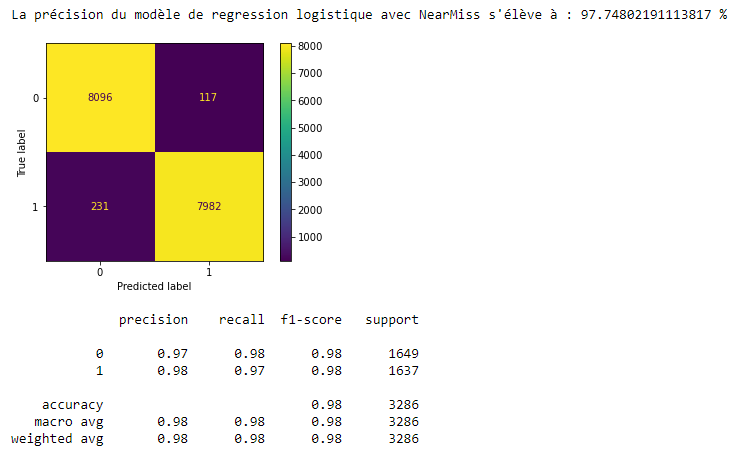

In [46]:
def reg_log_nm():
    
    
    #redéfinition de X et y
    #X=df_encoded.drop('isFraud', axis=1)
    #y=df_encoded['isFraud']
    
    #data = df.values
    
    #y = LabelEncoder().fit_transform(y)
    
    #répartir les variables équitablement, mise en place du NearMiss
    #distribution_of_samples = {0:8213, 1:8213}
    #nearmiss = NearMiss(sampling_strategy = distribution_of_samples)
    #x_under_samples, y_under_samples = nearmiss.fit_sample(X,y)
    
    #print(nearmiss)
    
    
    #x_train,x_test,y_train,y_test=train_test_split(x_under_samples,y_under_samples,test_size=0.2,random_state=42)

        # instancier le modèle
    #clf=LogisticRegression(solver='newton-cg')

        # entraîner le modèle
    #clf.fit(x_train,y_train)
    #pred=clf.predict(x_test)
    
    #print("La précision du modèle de regression logistique avec NearMiss s'élève à :", accuracy_score(y_test,pred)*100, "%")
    
    #plot_confusion_matrix(clf, x_under_samples, y_under_samples)
    #plt.show()
    
    #print(classification_report(y_test,pred))
    
    #affichage de la capture des résultats
    print("Modèle d'underfitting avec NearMiss")
    display(Image(filename='reg_log_nm.png')) 
    
    
    
reg_log_nm()    

# Arbre de décision

In [30]:
def dt2():
    print("Utilisez les chiffres pour naviguer :")
    print ("1/ Arbre de décision normal")
    print ("2/ Arbre de décision par over-fitting (SMOTE)")
    print ("3/ Arbre de décision par under-fitting (NearMiss)")
    print ("4/ Retour au menu principal")
    #x doit etre un chiffre et sinon ne pas renvoyer d'erreurs
    x = True
    while x != False: 
        x = input("Veuillez entrer un chiffre correspondant au menu souhaité : ")
        if x == "1" :
            dt()
        elif x == "2" :
            dtsmote()
        elif x == "3" :
            dtnm()
        elif x == "4" :
            main()
            
dt2()

Utilisez les chiffres pour naviguer :
1/ Arbre de décision normal
2/ Arbre de décision par over-fitting (SMOTE)
3/ Arbre de décision par under-fitting (NearMiss)
4/ Retour au menu principal


KeyboardInterrupt: Interrupted by user

# Arbre de décision normal

Modèle normal d'arbre de décision


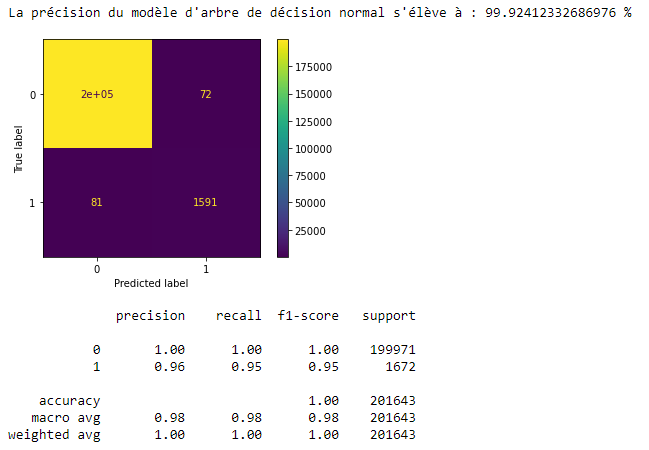

In [31]:
def dt():

    #X=df_encoded.drop('isFraud', axis=1)
    #y=df_encoded['isFraud']
    
    
    #X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=6)
    #decision_tree = DecisionTreeClassifier(criterion = "entropy", random_state=0)
    #decision_tree = decision_tree.fit(X_train, y_train)
    
    #pred=decision_tree.predict(X_test)
    
    #print("La précision du modèle d'arbre de décision normal s'élève à :", accuracy_score(y_test,pred)*100, "%")
    
    #plot_confusion_matrix(decision_tree, X_test, y_test)  
    #plt.show()
    
    #print(classification_report(y_test,pred))
    
    #permet d'exporter l'arbre et de le récupérer en PDF
    #dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns) 
    #graph = graphviz.Source(dot_data) 
    #graph.render("bank")
    
    print("Modèle normal d'arbre de décision")
    display(Image(filename='dt.png'))
    
dt()

# Arbre de décision avec SMOTE 

Modèle d'overfitting d'arbre de décision


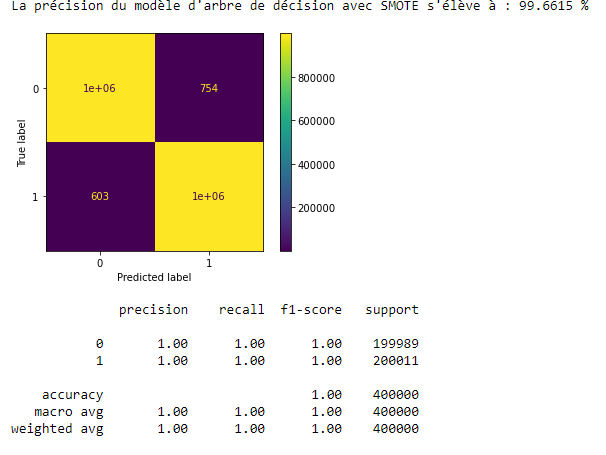

In [48]:
def dtsmote():
    
    
    #on redéfini les variables
    #X=df_encoded.drop('isFraud', axis=1)
    #y=df_encoded['isFraud']
    
    
    #data = df.values
    
    #mise en place du SMOTE
    #seed = 5
    #smote = SMOTE(sampling_strategy='auto', random_state=seed,k_neighbors=7)
    #X_smote, y_smote = smote.fit_sample(X, y)
    
    #print(smote)
    
    #X_train,X_test,y_train,y_test=train_test_split(X_smote,y_smote,test_size=0.2,random_state=6)
    #decision_tree = DecisionTreeClassifier(criterion = "entropy", random_state=0)
    #decision_tree = decision_tree.fit(X_train, y_train)
    
    #pred=decision_tree.predict(X_test)
    
    #print("La précision du modèle d'arbre de décision avec SMOTE s'élève à :", accuracy_score(y_test,pred)*100, "%")
    
    #plot_confusion_matrix(decision_tree, X_smote, y_smote)  
    #plt.show()
    
    #print(classification_report(y_test,pred))
    
    #permet d'exporter l'arbre et de le récupérer en PDF
    #dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns) 
    #graph = graphviz.Source(dot_data) 
    #graph.render("bank")
    
    print("Modèle d'overfitting d'arbre de décision")
    display(Image(filename='dtsmote.png'))    
    
dtsmote()    

# Arbre de décision avec NearMiss

Modèle d'underfitting d'arbre de décision


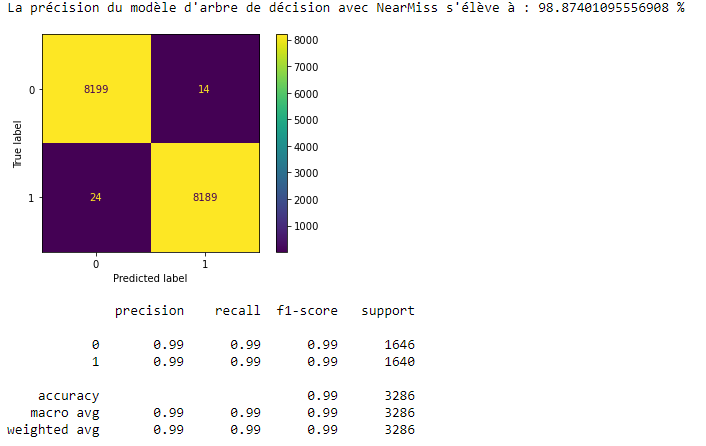

In [79]:
def dtnm():

    #X=df_encoded.drop('isFraud', axis=1)
    #y=df_encoded['isFraud']
    
    #data = df.values
    
    #y = LabelEncoder().fit_transform(y)
    
    #distribution_of_samples = {0:8213, 1:8213}
    #nearmiss = NearMiss(sampling_strategy = distribution_of_samples)
    #X_under_samples, y_under_samples = nearmiss.fit_sample(X,y)
    
    #print(nearmiss)

    #X_train,X_test,y_train,y_test=train_test_split(X_under_samples,y_under_samples,test_size=0.2,random_state=6)
    #decision_tree = DecisionTreeClassifier(criterion = "entropy", random_state=0)
    #decision_tree = decision_tree.fit(X_train, y_train)
    
    #pred=decision_tree.predict(X_test)
    
    #print("La précision du modèle d'arbre de décision avec NearMiss s'élève à :", accuracy_score(y_test,pred)*100, "%")
    
    #plot_confusion_matrix(decision_tree, X_under_samples, y_under_samples)  
    #plt.show()
    
    #print(classification_report(y_test,pred))
    
    #permet d'exporter l'arbre et de le récupérer en PDF
    #dot_data = tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns) 
    #graph = graphviz.Source(dot_data) 
    #graph.render("bank") 
    
    print("Modèle d'underfitting d'arbre de décision")
    display(Image(filename='dtnm.png'))
    
dtnm()    

# Random Forest

In [34]:
def rf2():
    print("Utilisez les chiffres pour naviguer :")
    print ("1/ Random forest normale")
    print ("2/ Random forest par over-fitting (SMOTE)")
    print ("3/ Random forest par under-fitting (NearMiss)")
    print ("4/ Retour au menu principal")
    #x doit etre un chiffre et sinon ne pas renvoyer d'erreurs
    x = True
    while x != False: 
        x = input("Veuillez entrer un chiffre correspondant au menu souhaité : ")
        if x == "1" :
            rf()
        elif x == "2" :
            rfsmote()
        elif x == "3" :
            rfnm()
        elif x == "4" :
            main()
            
dt2()

Utilisez les chiffres pour naviguer :
1/ Arbre de décision normal
2/ Arbre de décision par over-fitting (SMOTE)
3/ Arbre de décision par under-fitting (NearMiss)
4/ Retour au menu principal


KeyboardInterrupt: Interrupted by user

# Random Forest normale

Modèle normale de random forest


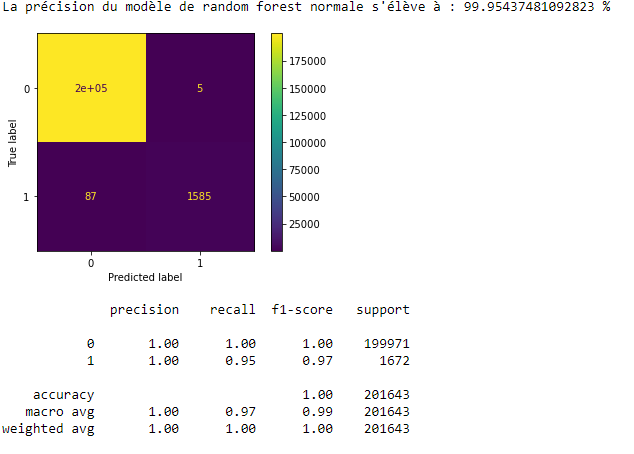

In [35]:
def rf():
    
    #X=df_encoded.drop('isFraud', axis=1)
    #y=df_encoded['isFraud']
    
    #x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=6)
    
    #clf = RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=30)
    #clf.fit(x_train, y_train)
    
    #pred = clf.predict(x_test)
    
    #print("La précision du modèle de random forest normale s'élève à :", accuracy_score(y_test,pred)*100, "%")
    
    #plot_confusion_matrix(clf, x_test, y_test)  
    #plt.show()
    
    #print(classification_report(y_test,pred))
    
    print("Modèle normale de random forest")
    display(Image(filename='rf.png'))
    
rf()    

# Random Forest avec SMOTE

Modèle de random forest avec SMOTE


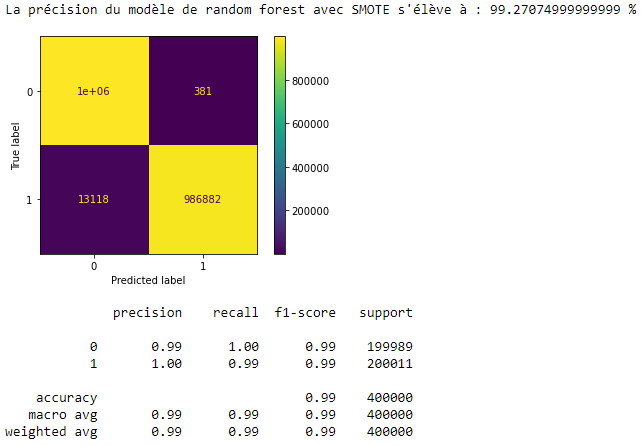

In [36]:
def rfsmote():
    
    #X=df_encoded.drop('isFraud', axis=1)
    #y=df_encoded['isFraud']
    
    #data = df.values
    
    #seed = 5
    #smote = SMOTE(sampling_strategy='auto', random_state=seed,k_neighbors=7)
    #X_smote, y_smote = smote.fit_sample(X, y)
    
    #print(smote)
    
    #x_train,x_test,y_train,y_test=train_test_split(X_smote,y_smote,test_size=0.2,random_state=6)
    
    #clf = RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=30)
    #clf.fit(x_train, y_train)
    
    #pred = clf.predict(x_test)
    
    #print("La précision du modèle de random forest avec SMOTE s'élève à :", accuracy_score(y_test,pred)*100, "%")
    
    #plot_confusion_matrix(clf, X_smote, y_smote)  
    #plt.show()
    
    #print(classification_report(y_test,pred))
    
    print("Modèle de random forest avec SMOTE")
    display(Image(filename='rfsmote.png'))
    
rfsmote()

# Random Forest avec NearMiss

Modèle de random forest avec NearMiss


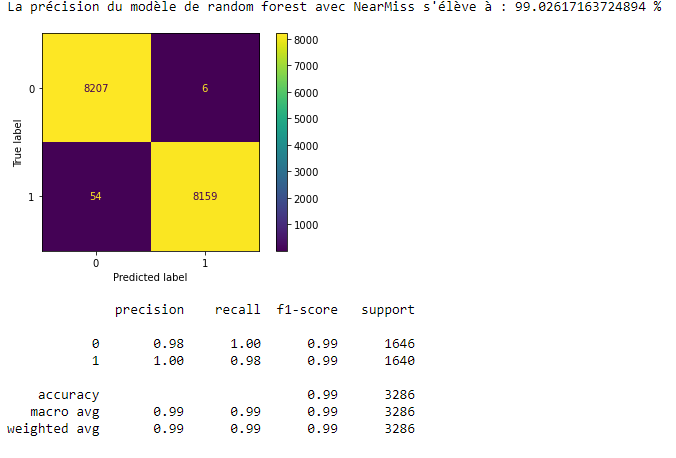

In [37]:
def rfnm():
    
    #X=df_encoded.drop('isFraud', axis=1)
    #y=df_encoded['isFraud']
    
    #data = df.values
    
    #distribution_of_samples = {0:8213, 1:8213}
    #nearmiss = NearMiss(sampling_strategy = distribution_of_samples)
    #X_under_samples, y_under_samples = nearmiss.fit_sample(X,y)
    
    #print(nearmiss)
    
    #x_train,x_test,y_train,y_test=train_test_split(X_under_samples,y_under_samples,test_size=0.2,random_state=6)
    
    #clf = RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=30)
    #clf.fit(x_train, y_train)
    
    #pred = clf.predict(x_test)
    
    #print("La précision du modèle de random forest avec NearMiss s'élève à :", accuracy_score(y_test,pred)*100, "%")
    
    #plot_confusion_matrix(clf, X_under_samples, y_under_samples)  
    #plt.show()
    
    #print(classification_report(y_test,pred))
    
    print("Modèle de random forest avec NearMiss")
    display(Image(filename='rfnm.png'))
    
rfnm()